In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
house_prices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [4]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Off the bat it looks like there are going to be some missing values we'll need to handle. So let's take care of those first.

In [5]:
house_prices_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1460,NaN,NaN,NaN,730.5,421.61,1,365.75,730.5,1095.25,1460
mssubclass,1460,NaN,NaN,NaN,56.8973,42.3006,20,20,50,70,190
mszoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lotfrontage,1201,NaN,NaN,NaN,70.05,24.2848,21,59,69,80,313
lotarea,1460,NaN,NaN,NaN,10516.8,9981.26,1300,7553.5,9478.5,11601.5,215245
street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lotshape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
landcontour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


Since we do not know which of these features could be valuable to our model, we need to quickly analyze if any of them are relevant to our target 'saleprice'.

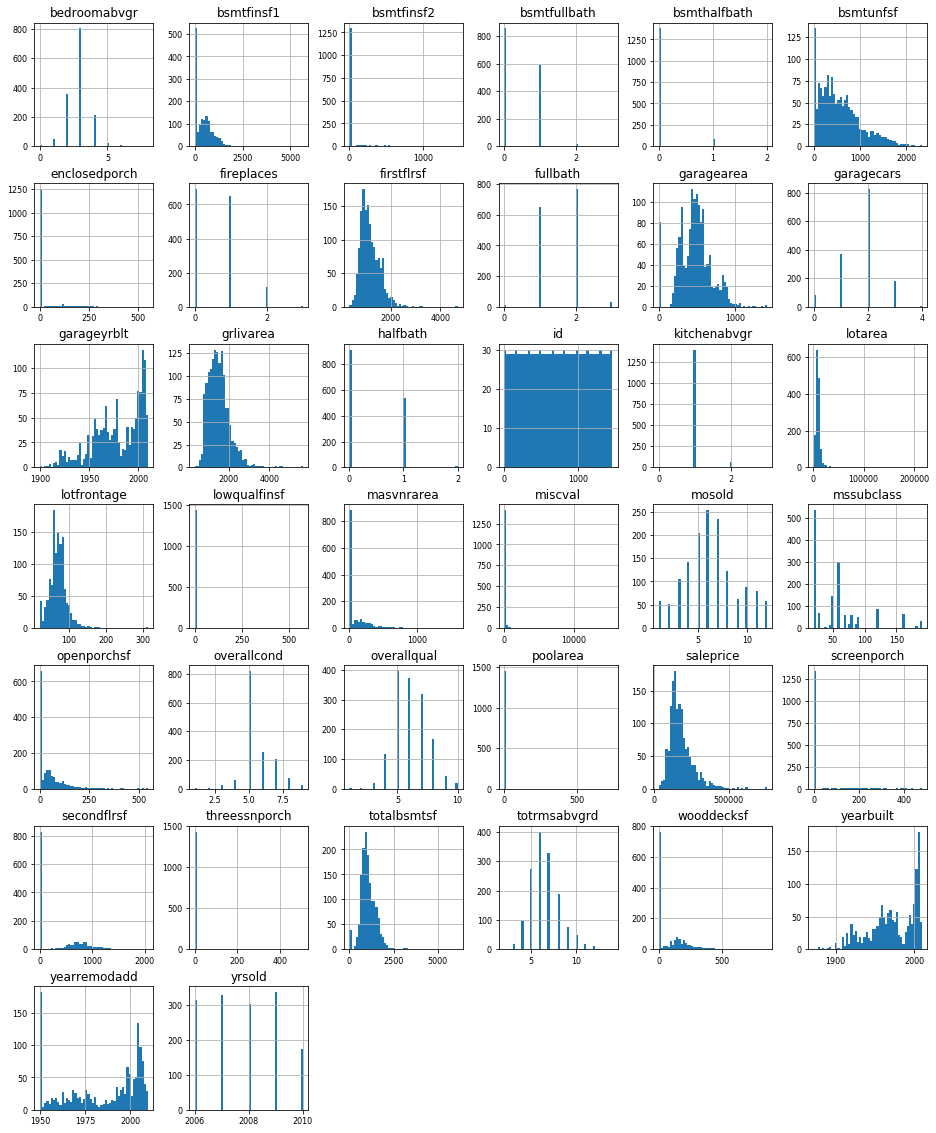

In [7]:
house_prices_df[numeric_columns].hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

Some interesting distributions from our numeric columns include:
- firstflrsf
- grlivarea
- lotfrontage
- totalbsmtsf

We will explore these more after we handle any of the missing values in our features.

We will need to convert any non-numerical variables into numerical columns for possible use in our model when relevant.

In [8]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


## Onto handling any Missing Values

In [9]:
total_missing = house_prices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_prices_df.isnull().sum()/house_prices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0].head(30)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


After analyzing the missing values we identified 15% as the constant for missing_values we did not feel comfortable filling missing values of so we chose to remove those from possible use in the model.

In [10]:
missing_values_threshold = 0.15

keep_cols = list(missing_data[missing_data.Percent <= missing_values_threshold].T.columns)
house_prices_df = house_prices_df[keep_cols]

# house_prices_df.columns

### Time to take care of the garage features

We can see that all 5 variables associated to garage features are missing an identical amount of records (81 in total) so lets check the raw data out first to see if we find any trends in the missing data records.

In [11]:
cols = list(missing_data[((missing_data['Percent'] <= missing_values_threshold) & (missing_data['Total'] > 0))].T.columns)

cols.append('saleprice')
cols.append('garagecars')
cols.append('garagearea')
house_prices_df[cols].head(100)

,garagecond,garagetype,garageyrblt,garagefinish,garagequal,bsmtexposure,bsmtfintype2,bsmtfintype1,bsmtcond,bsmtqual,masvnrarea,masvnrtype,electrical,saleprice,garagecars,garagearea
0,TA,Attchd,2003.0,RFn,TA,No,Unf,GLQ,TA,Gd,196.0,BrkFace,SBrkr,208500,2,548
1,TA,Attchd,1976.0,RFn,TA,Gd,Unf,ALQ,TA,Gd,0.0,None,SBrkr,181500,2,460
2,TA,Attchd,2001.0,RFn,TA,Mn,Unf,GLQ,TA,Gd,162.0,BrkFace,SBrkr,223500,2,608
3,TA,Detchd,1998.0,Unf,TA,No,Unf,ALQ,Gd,TA,0.0,None,SBrkr,140000,3,642
4,TA,Attchd,2000.0,RFn,TA,Av,Unf,GLQ,TA,Gd,350.0,BrkFace,SBrkr,250000,3,836
5,TA,Attchd,1993.0,Unf,TA,No,Unf,GLQ,TA,Gd,0.0,None,SBrkr,143000,2,480
6,TA,Attchd,2004.0,RFn,TA,Av,Unf,GLQ,TA,Ex,186.0,Stone,SBrkr,307000,2,636
7,TA,Attchd,1973.0,RFn,TA,Mn,BLQ,ALQ,TA,Gd,240.0,Stone,SBrkr,200000,2,484
8,TA,Detchd,1931.0,Unf,Fa,No,Unf,Unf,TA,TA,0.0,None,FuseF,129900,2,468
9,TA,Attchd,1939.0,RFn,Gd,No,Unf,GLQ,TA,TA,0.0,None,SBrkr,118000,1,205


From visually analysing the garage features we can see that records indicate normally they are all missing values when the 'garagecars' value is 0. So we are going to drop all garage features other than 'garagecars' and 'garagearea' to reduce the possibility of Multicolinearity. 

In [12]:
garage_features = ['garagecond', 'garagetype', 'garagefinish', 'garagequal', 'garageyrblt']

house_prices_df_clean = house_prices_df.drop(garage_features, axis=1)

print(house_prices_df_clean.columns)

Index(['bsmtexposure', 'bsmtfintype2', 'bsmtfintype1', 'bsmtcond', 'bsmtqual',
       'masvnrarea', 'masvnrtype', 'electrical', 'utilities', 'yearremodadd',
       'mssubclass', 'foundation', 'extercond', 'exterqual', 'exterior2nd',
       'exterior1st', 'roofmatl', 'roofstyle', 'yearbuilt', 'lotconfig',
       'overallcond', 'overallqual', 'housestyle', 'bldgtype', 'condition2',
       'bsmtfinsf1', 'mszoning', 'lotarea', 'street', 'condition1',
       'neighborhood', 'lotshape', 'landcontour', 'landslope', 'saleprice',
       'heatingqc', 'bsmtfinsf2', 'enclosedporch', 'fireplaces', 'garagecars',
       'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
       'threessnporch', 'bsmtunfsf', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saletype', 'functional', 'totrmsabvgrd',
       'kitchenqual', 'kitchenabvgr', 'bedroomabvgr', 'halfbath', 'fullbath',
       'bsmthalfbath', 'bsmtfullbath', 'grlivarea', 'lowqualfinsf',
       'secondflrsf', 'firstflrsf', 'cen

### Next are the basement_features

In [13]:
house_prices_df_clean.head(100)

,bsmtexposure,bsmtfintype2,bsmtfintype1,bsmtcond,bsmtqual,masvnrarea,masvnrtype,electrical,utilities,yearremodadd,...,bsmtfullbath,grlivarea,lowqualfinsf,secondflrsf,firstflrsf,centralair,salecondition,heating,totalbsmtsf,id
0,No,Unf,GLQ,TA,Gd,196.0,BrkFace,SBrkr,AllPub,2003,...,1,1710,0,854,856,Y,Normal,GasA,856,1
1,Gd,Unf,ALQ,TA,Gd,0.0,None,SBrkr,AllPub,1976,...,0,1262,0,0,1262,Y,Normal,GasA,1262,2
2,Mn,Unf,GLQ,TA,Gd,162.0,BrkFace,SBrkr,AllPub,2002,...,1,1786,0,866,920,Y,Normal,GasA,920,3
3,No,Unf,ALQ,Gd,TA,0.0,None,SBrkr,AllPub,1970,...,1,1717,0,756,961,Y,Abnorml,GasA,756,4
4,Av,Unf,GLQ,TA,Gd,350.0,BrkFace,SBrkr,AllPub,2000,...,1,2198,0,1053,1145,Y,Normal,GasA,1145,5
5,No,Unf,GLQ,TA,Gd,0.0,None,SBrkr,AllPub,1995,...,1,1362,0,566,796,Y,Normal,GasA,796,6
6,Av,Unf,GLQ,TA,Ex,186.0,Stone,SBrkr,AllPub,2005,...,1,1694,0,0,1694,Y,Normal,GasA,1686,7
7,Mn,BLQ,ALQ,TA,Gd,240.0,Stone,SBrkr,AllPub,1973,...,1,2090,0,983,1107,Y,Normal,GasA,1107,8
8,No,Unf,Unf,TA,TA,0.0,None,FuseF,AllPub,1950,...,0,1774,0,752,1022,Y,Abnorml,GasA,952,9
9,No,Unf,GLQ,TA,TA,0.0,None,SBrkr,AllPub,1950,...,1,1077,0,0,1077,Y,Normal,GasA,991,10


In [14]:
basement_features = ['bsmtexposure', 'bsmtfintype2', 'bsmtfintype1', 'bsmtcond', 'bsmtqual']

house_prices_df_clean = house_prices_df_clean.drop(basement_features, axis=1)

print(house_prices_df_clean.columns)

Index(['masvnrarea', 'masvnrtype', 'electrical', 'utilities', 'yearremodadd',
       'mssubclass', 'foundation', 'extercond', 'exterqual', 'exterior2nd',
       'exterior1st', 'roofmatl', 'roofstyle', 'yearbuilt', 'lotconfig',
       'overallcond', 'overallqual', 'housestyle', 'bldgtype', 'condition2',
       'bsmtfinsf1', 'mszoning', 'lotarea', 'street', 'condition1',
       'neighborhood', 'lotshape', 'landcontour', 'landslope', 'saleprice',
       'heatingqc', 'bsmtfinsf2', 'enclosedporch', 'fireplaces', 'garagecars',
       'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
       'threessnporch', 'bsmtunfsf', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saletype', 'functional', 'totrmsabvgrd',
       'kitchenqual', 'kitchenabvgr', 'bedroomabvgr', 'halfbath', 'fullbath',
       'bsmthalfbath', 'bsmtfullbath', 'grlivarea', 'lowqualfinsf',
       'secondflrsf', 'firstflrsf', 'centralair', 'salecondition', 'heating',
       'totalbsmtsf', 'id'],
      dtype=

### Last up are the 'masvnrarea', 'masvnrtype' (meaning _'Masonry Veneer'_), and 'electrical' 

In [15]:
house_prices_df_clean.head(100)

,masvnrarea,masvnrtype,electrical,utilities,yearremodadd,mssubclass,foundation,extercond,exterqual,exterior2nd,...,bsmtfullbath,grlivarea,lowqualfinsf,secondflrsf,firstflrsf,centralair,salecondition,heating,totalbsmtsf,id
0,196.0,BrkFace,SBrkr,AllPub,2003,60,PConc,TA,Gd,VinylSd,...,1,1710,0,854,856,Y,Normal,GasA,856,1
1,0.0,None,SBrkr,AllPub,1976,20,CBlock,TA,TA,MetalSd,...,0,1262,0,0,1262,Y,Normal,GasA,1262,2
2,162.0,BrkFace,SBrkr,AllPub,2002,60,PConc,TA,Gd,VinylSd,...,1,1786,0,866,920,Y,Normal,GasA,920,3
3,0.0,None,SBrkr,AllPub,1970,70,BrkTil,TA,TA,Wd Shng,...,1,1717,0,756,961,Y,Abnorml,GasA,756,4
4,350.0,BrkFace,SBrkr,AllPub,2000,60,PConc,TA,Gd,VinylSd,...,1,2198,0,1053,1145,Y,Normal,GasA,1145,5
5,0.0,None,SBrkr,AllPub,1995,50,Wood,TA,TA,VinylSd,...,1,1362,0,566,796,Y,Normal,GasA,796,6
6,186.0,Stone,SBrkr,AllPub,2005,20,PConc,TA,Gd,VinylSd,...,1,1694,0,0,1694,Y,Normal,GasA,1686,7
7,240.0,Stone,SBrkr,AllPub,1973,60,CBlock,TA,TA,HdBoard,...,1,2090,0,983,1107,Y,Normal,GasA,1107,8
8,0.0,None,FuseF,AllPub,1950,50,BrkTil,TA,TA,Wd Shng,...,0,1774,0,752,1022,Y,Abnorml,GasA,952,9
9,0.0,None,SBrkr,AllPub,1950,190,BrkTil,TA,TA,MetalSd,...,1,1077,0,0,1077,Y,Normal,GasA,991,10


In [16]:
house_prices_df_clean.masvnrarea.fillna(0, inplace=True)
house_prices_df_clean.masvnrtype.fillna('None', inplace=True)

# Since there was only 1 record missing an 'electrical' value we will use the Mode value for it which is "Standard Circuit"->"SBrkr"
house_prices_df_clean.electrical.fillna('SBrkr', inplace=True)

Let's do a quick check to see if there are anymore missing values to take care of:

In [17]:
total_missing = house_prices_df_clean.isnull().sum().sort_values(ascending=False)
percent_missing = (house_prices_df_clean.isnull().sum()/house_prices_df_clean.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0].head(30)

,Total,Percent


Niceeee. Now we need to get numerical values for some of our categorical variables:

In [18]:
categorical_cols_df = pd.concat([house_prices_df_clean,pd.get_dummies(house_prices_df_clean.masvnrtype, prefix="masonry")], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.masvnrtype, prefix="masonry").columns)

categorical_cols_df[dummy_column_names].head()

,masonry_BrkCmn,masonry_BrkFace,masonry_None,masonry_Stone
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,1,0,0


In [19]:
categorical_cols_df = pd.concat([categorical_cols_df,pd.get_dummies(house_prices_df_clean.electrical, prefix="electrical")], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.electrical, prefix="electrical").columns)

categorical_cols_df[dummy_column_names].head()

,electrical_FuseA,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


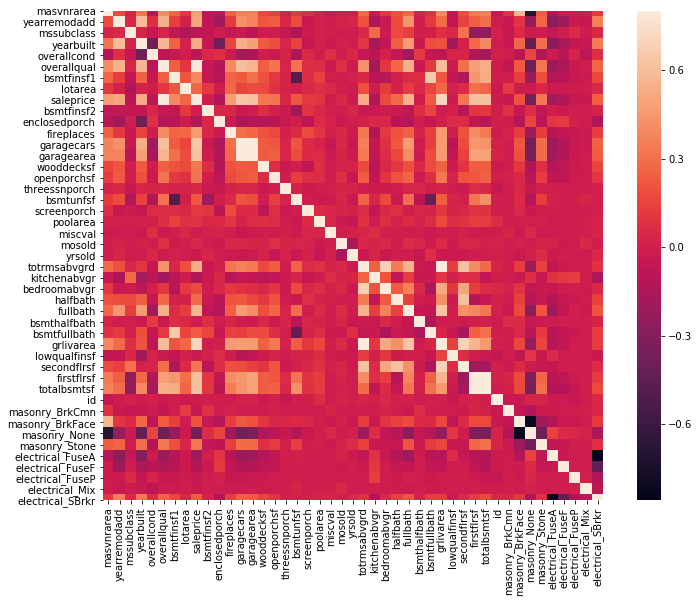

In [20]:
corrmat_dummies = categorical_cols_df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat_dummies, vmax=.8, square=True)

In [21]:
last_cols_removed = ['masvnrarea','masvnrtype','electrical']

house_prices_df_clean = house_prices_df_clean.drop(last_cols_removed, axis=1)

print(house_prices_df_clean.columns)

Index(['utilities', 'yearremodadd', 'mssubclass', 'foundation', 'extercond',
       'exterqual', 'exterior2nd', 'exterior1st', 'roofmatl', 'roofstyle',
       'yearbuilt', 'lotconfig', 'overallcond', 'overallqual', 'housestyle',
       'bldgtype', 'condition2', 'bsmtfinsf1', 'mszoning', 'lotarea', 'street',
       'condition1', 'neighborhood', 'lotshape', 'landcontour', 'landslope',
       'saleprice', 'heatingqc', 'bsmtfinsf2', 'enclosedporch', 'fireplaces',
       'garagecars', 'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
       'threessnporch', 'bsmtunfsf', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saletype', 'functional', 'totrmsabvgrd',
       'kitchenqual', 'kitchenabvgr', 'bedroomabvgr', 'halfbath', 'fullbath',
       'bsmthalfbath', 'bsmtfullbath', 'grlivarea', 'lowqualfinsf',
       'secondflrsf', 'firstflrsf', 'centralair', 'salecondition', 'heating',
       'totalbsmtsf', 'id'],
      dtype='object')


Since Masonry and electrical work are not a well known features to buying houses in today's market and as you'll see below there are other features like 'yearbuilt' and 'overallqual' that are highly correlated to it so we will remove these from our model as well. 

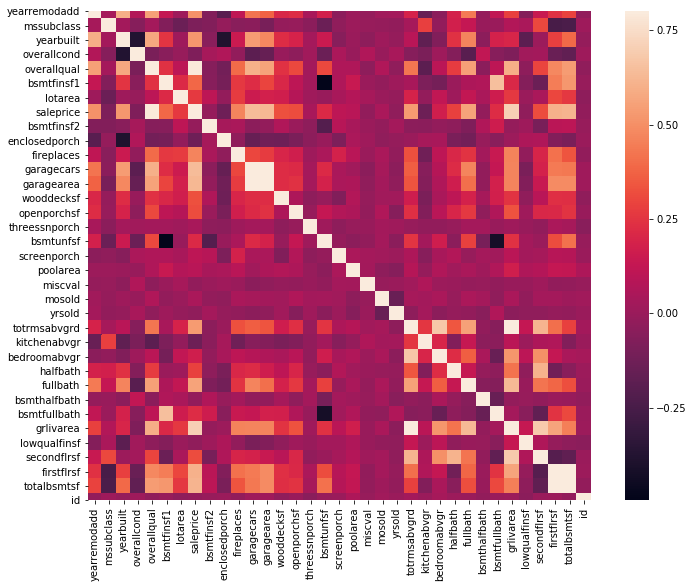

In [22]:
corrmat = house_prices_df_clean.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

# make an absolute correlation matrix
# bring up the correlation list from the EDA process

## Exploratory Data Analysis

#### Missing Values have been handled. Now we need to run some tests to identify if there are any outliers in our data as well as the distribution tendencies

We will start with 'saleprice' since it is our target variable.

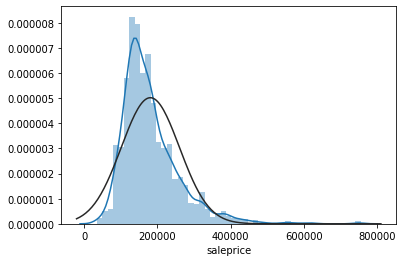

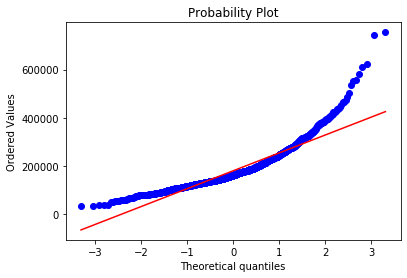

In [23]:
from scipy.stats import norm

sns.distplot(house_prices_df_clean['saleprice'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_prices_df_clean['saleprice'], plot=plt)

Looks like our target variable is Skewed so we'll need to handle this.

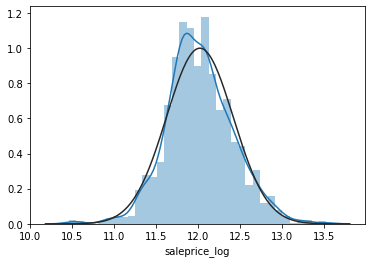

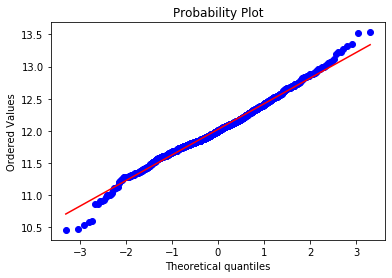

In [24]:
# applying log transformation
house_prices_df_clean['saleprice_log'] = np.log(house_prices_df_clean.saleprice)


sns.distplot(house_prices_df_clean['saleprice_log'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_prices_df_clean['saleprice_log'], plot=plt)

First try's a charm from the looks of it but we can also run it through a quick normality test to confirm:

In [25]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(house_prices_df_clean.saleprice)
norm_stats = normaltest(house_prices_df_clean.saleprice)

print('saleprice stats: \n')
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


jb_stats = jarque_bera(house_prices_df_clean.saleprice_log)
norm_stats = normaltest(house_prices_df_clean.saleprice_log)

print('\nsaleprice (log transformed) stats: \n')
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

saleprice stats: 

Jarque-Bera test statistics is 3438.8721241220583 and p value is 0.0
Normality test statistics is 610.8359109472653 and p value is 2.283848353787728e-133

saleprice (log transformed) stats: 

Jarque-Bera test statistics is 42.7672735832514 and p value is 5.166596039885007e-10
Normality test statistics is 25.507009834238268 and p value is 2.8921658220524008e-06


That's great! Our tests show statistical significance for both normality tests after log transformation.

#### As an additional Note: 
- To keep the model consistent from this point on we will be using only log transformations for any features that are chosen for the model if they are not normally distributed.

#### Now let's take a look at the rest of our numerical features to pick out the ones that might be relevant to add into our model

In [26]:
numeric_columns = house_prices_df_clean.select_dtypes(['int64', 'float64']).columns
# print(numeric_columns)

print(np.abs(house_prices_df_clean.drop('saleprice', axis=1).iloc[:,1:].corr().loc[:,"saleprice_log"]).sort_values(ascending=False), "\n")

feature_correlations = np.abs(house_prices_df_clean.drop('saleprice', axis=1).iloc[:,1:].corr().loc[:,"saleprice_log"]).sort_values(ascending=False)

# OLD CODE that has negative correlations
# feature_correlations = house_prices_df_clean.drop('saleprice', axis=1).corr()
# print(feature_correlations['saleprice_log'].sort_values(ascending= False), '\n')

saleprice_log    1.000000
overallqual      0.817184
grlivarea        0.700927
garagecars       0.680625
garagearea       0.650888
totalbsmtsf      0.612134
firstflrsf       0.596981
fullbath         0.594771
yearbuilt        0.586570
yearremodadd     0.565608
totrmsabvgrd     0.534422
fireplaces       0.489449
bsmtfinsf1       0.372023
wooddecksf       0.334135
openporchsf      0.321053
secondflrsf      0.319300
halfbath         0.313982
lotarea          0.257320
bsmtfullbath     0.236224
bsmtunfsf        0.221985
bedroomabvgr     0.209044
enclosedporch    0.149050
kitchenabvgr     0.147548
screenporch      0.121208
mssubclass       0.073959
poolarea         0.069798
mosold           0.057329
threessnporch    0.054900
lowqualfinsf     0.037963
yrsold           0.037263
overallcond      0.036868
miscval          0.020021
id               0.017942
bsmthalfbath     0.005149
bsmtfinsf2       0.004832
Name: saleprice_log, dtype: float64 



Looks like there are few features that could impact our model via multicollinearity including:
- "garagecars" + "garagearea" so we will be removing "garagearea" as it is an easier feature to understand and has a higher coefficient.
- "yearbuilt" + "yearremodadd" so we will be removing "yearremodadd" ('yearremodadd' in the readme states: Remodel date (same as construction date if no remodeling or additions) which is why they are similar coefficient values.
- We can see that basements are popular choices to buying a home and since there is a 'totalbsmtsf' feature available, we will only be using that feature (and removing the rest to reduce possible multicollinearity issues in our model).

In [27]:
print(feature_correlations)

saleprice_log    1.000000
overallqual      0.817184
grlivarea        0.700927
garagecars       0.680625
garagearea       0.650888
totalbsmtsf      0.612134
firstflrsf       0.596981
fullbath         0.594771
yearbuilt        0.586570
yearremodadd     0.565608
totrmsabvgrd     0.534422
fireplaces       0.489449
bsmtfinsf1       0.372023
wooddecksf       0.334135
openporchsf      0.321053
secondflrsf      0.319300
halfbath         0.313982
lotarea          0.257320
bsmtfullbath     0.236224
bsmtunfsf        0.221985
bedroomabvgr     0.209044
enclosedporch    0.149050
kitchenabvgr     0.147548
screenporch      0.121208
mssubclass       0.073959
poolarea         0.069798
mosold           0.057329
threessnporch    0.054900
lowqualfinsf     0.037963
yrsold           0.037263
overallcond      0.036868
miscval          0.020021
id               0.017942
bsmthalfbath     0.005149
bsmtfinsf2       0.004832
Name: saleprice_log, dtype: float64


In [28]:
feature_drop_list = ['garagearea', 'yearremodadd', 'bsmtunfsf', 'bsmtfinsf1', 'bsmtfinsf2']

house_prices_df_clean = house_prices_df_clean.drop(feature_drop_list, axis=1)

In [29]:
feature_correlations = house_prices_df_clean.drop('saleprice', axis=1).corr()
print(feature_correlations['saleprice_log'].sort_values(ascending= False), '\n')

saleprice_log    1.000000
overallqual      0.817184
grlivarea        0.700927
garagecars       0.680625
totalbsmtsf      0.612134
firstflrsf       0.596981
fullbath         0.594771
yearbuilt        0.586570
totrmsabvgrd     0.534422
fireplaces       0.489449
wooddecksf       0.334135
openporchsf      0.321053
secondflrsf      0.319300
halfbath         0.313982
lotarea          0.257320
bsmtfullbath     0.236224
bedroomabvgr     0.209044
screenporch      0.121208
poolarea         0.069798
mosold           0.057329
threessnporch    0.054900
bsmthalfbath    -0.005149
id              -0.017942
miscval         -0.020021
overallcond     -0.036868
yrsold          -0.037263
lowqualfinsf    -0.037963
mssubclass      -0.073959
kitchenabvgr    -0.147548
enclosedporch   -0.149050
Name: saleprice_log, dtype: float64 



Index(['saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'totalbsmtsf', 'firstflrsf'],
      dtype='object')


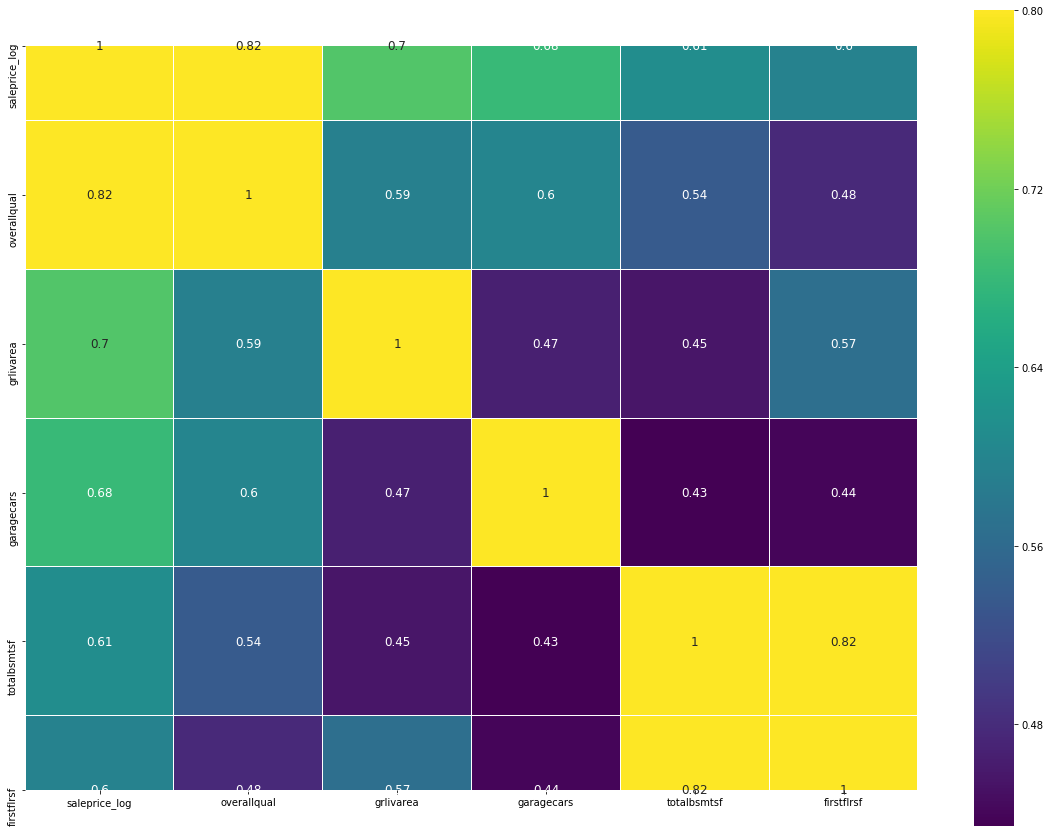

In [30]:
k= 6
cols = feature_correlations.nlargest(k,'saleprice_log')['saleprice_log'].index
print(cols)
cm = np.corrcoef(house_prices_df_clean[cols].values.T)
f , ax = plt.subplots(figsize = (20,15))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

## Applying threshold for absolute feature correlation

After reviewing the features we decided to stick with the **top 4 features that are above an absolute threshold of _~.59 coefficient value_** . As a note 'fullbath' was considered but it is normally seen as a secondary feature so it was not included in the initial creation of the model but could be added in during the model evaluation as a test of the models goodness.

In [31]:
total_num_model_features = len(cols)-1

print('Total Numerical Features used in Model: {}'.format(total_num_model_features))
print('\n {}'.format(cols))

num_features_df = pd.DataFrame(cols, columns=['num_feature_names'])

print(num_features_df)

Total Numerical Features used in Model: 5

 Index(['saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'totalbsmtsf', 'firstflrsf'],
      dtype='object')
  num_feature_names
0     saleprice_log
1       overallqual
2         grlivarea
3        garagecars
4       totalbsmtsf
5        firstflrsf


## Feature Engineering

In [32]:
non_numeric_columns = house_prices_df_clean.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['utilities', 'foundation', 'extercond', 'exterqual', 'exterior2nd',
       'exterior1st', 'roofmatl', 'roofstyle', 'lotconfig', 'housestyle',
       'bldgtype', 'condition2', 'mszoning', 'street', 'condition1',
       'neighborhood', 'lotshape', 'landcontour', 'landslope', 'heatingqc',
       'paveddrive', 'saletype', 'functional', 'kitchenqual', 'centralair',
       'salecondition', 'heating'],
      dtype='object')
The number of non-numerical columns is 27


Let's get a better understanding of our non-numerical features by running them through a univariate test with our target variable ('saleprice').

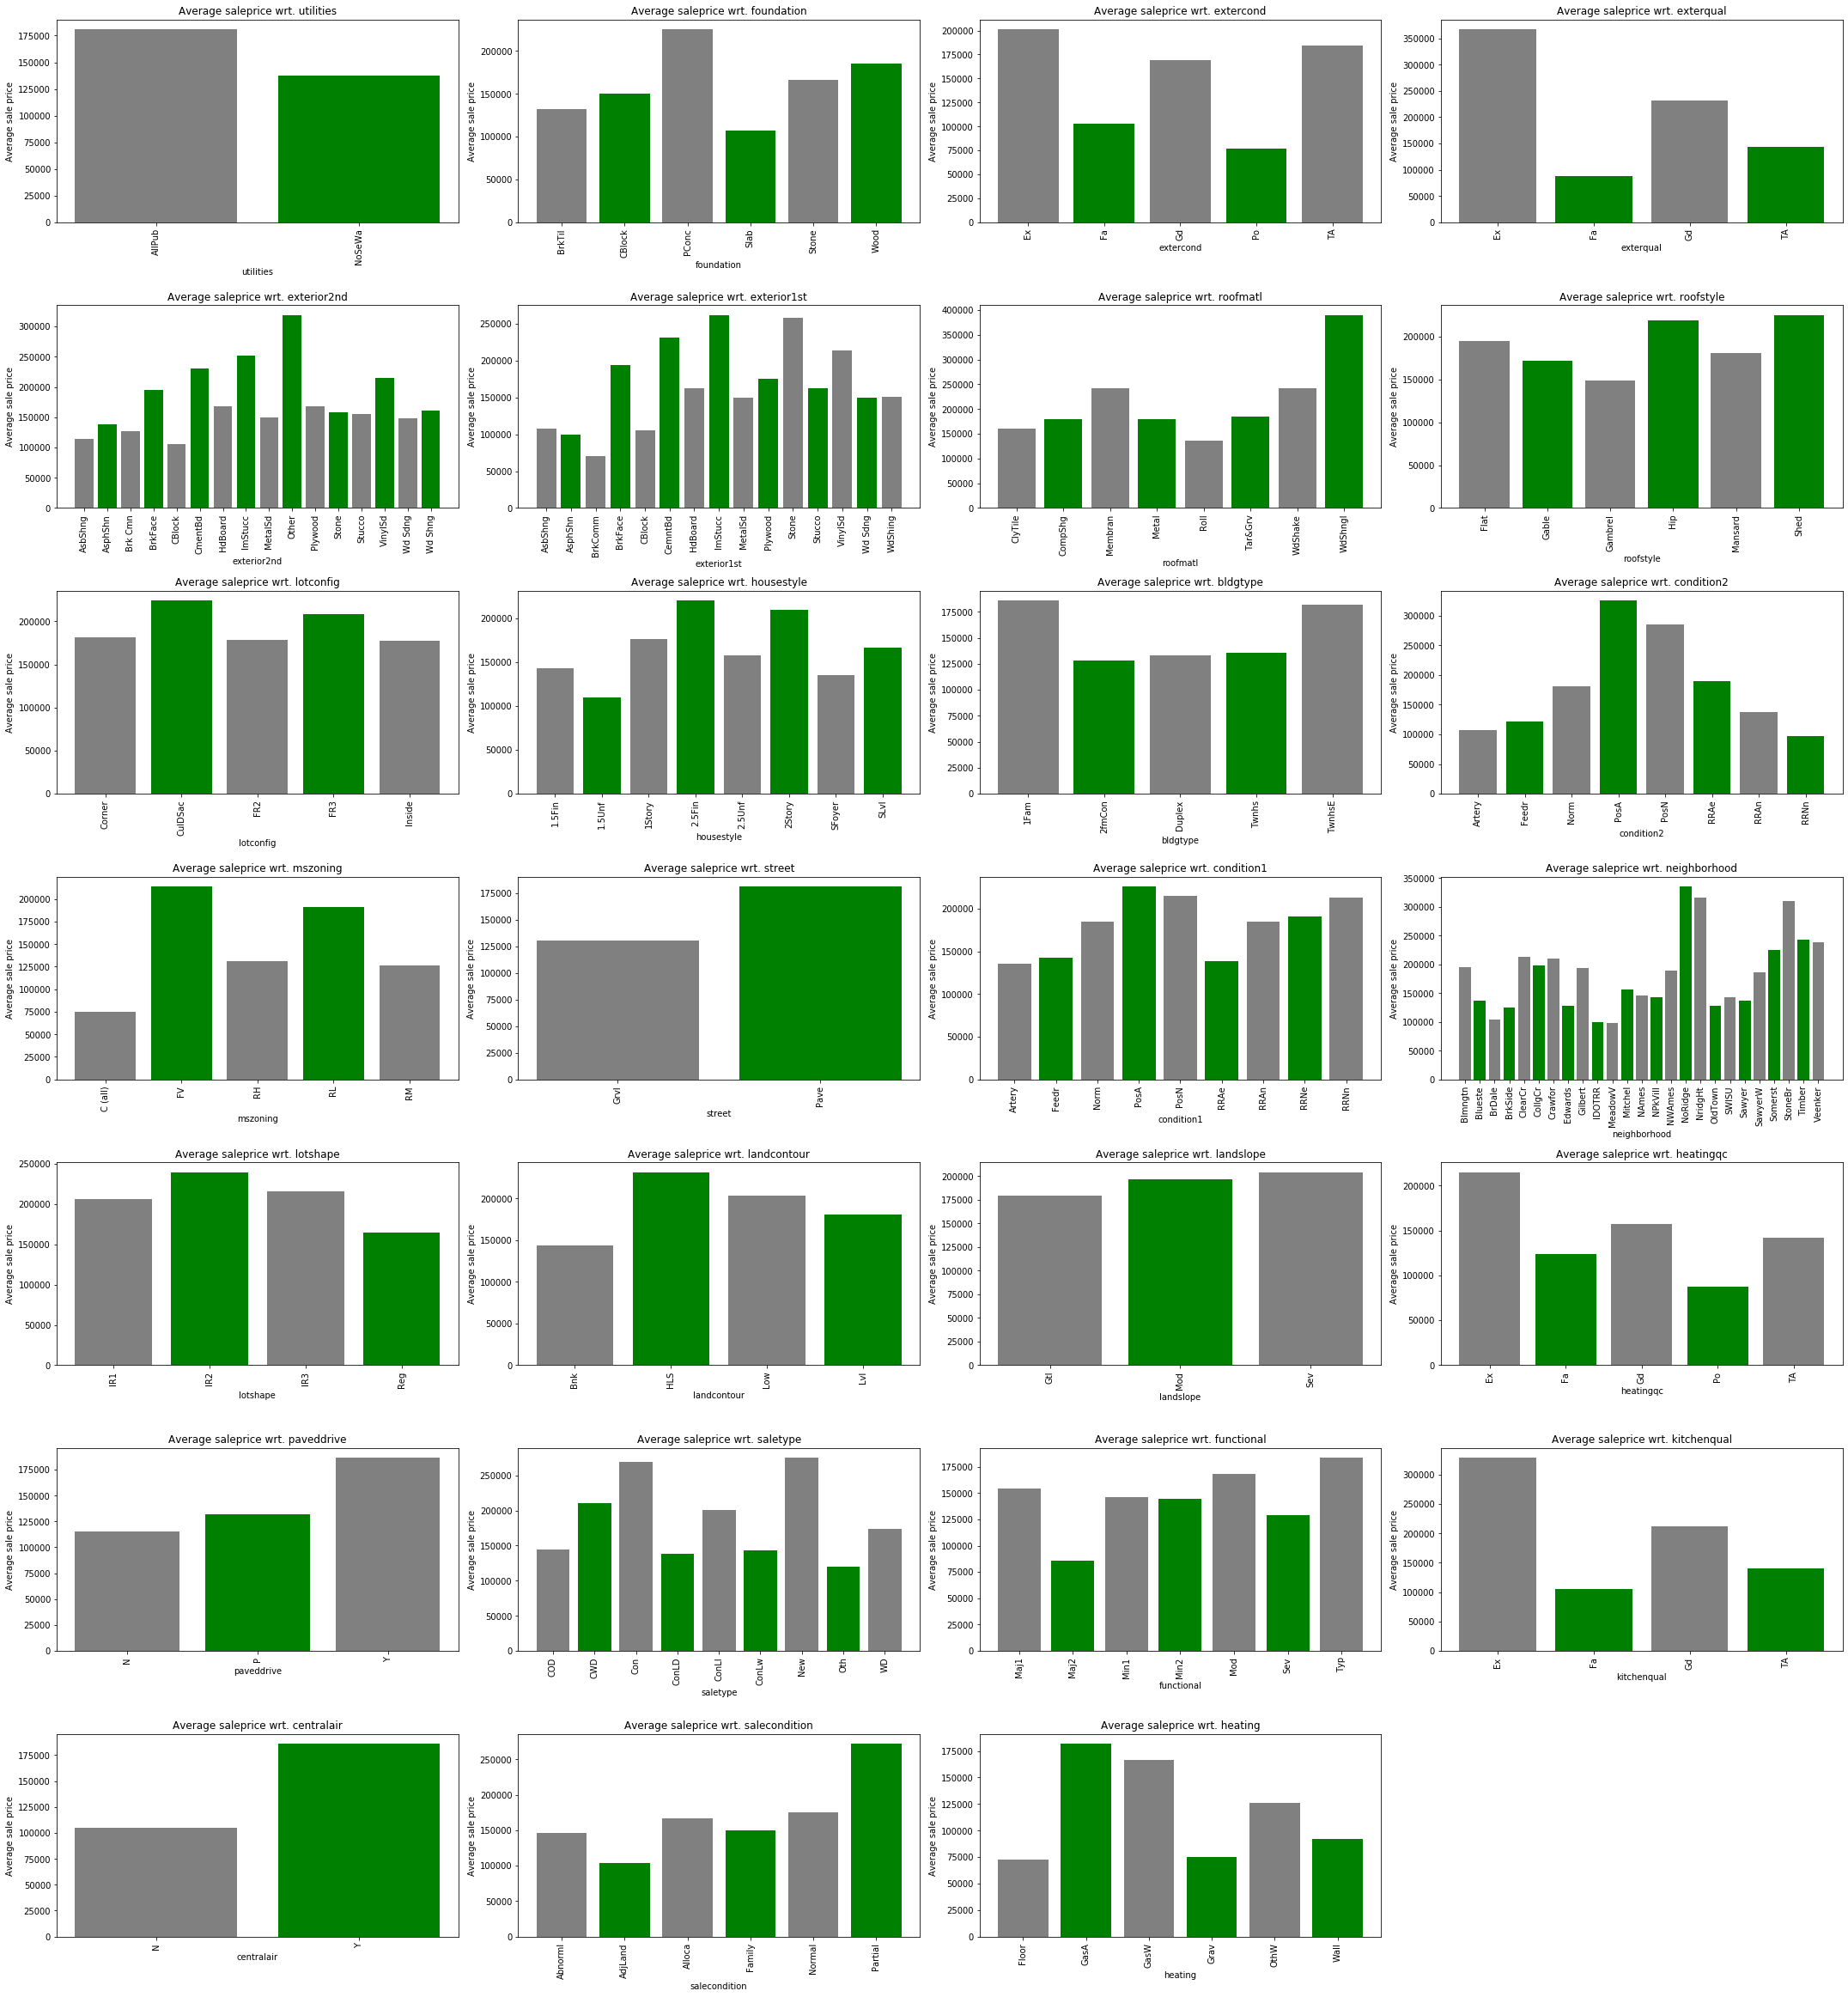

In [33]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df_clean.groupby(column)["saleprice"].mean().index, house_prices_df_clean.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

After reviewing the univariate tests we saw a couple categorical features that had high variances in relation to the mean 'saleprice'

In [34]:
categorical_features_dummies_list = ['mszoning', 'street']

for i in categorical_features_dummies_list:
    house_prices_df_clean = pd.concat([house_prices_df_clean, pd.get_dummies(house_prices_df_clean[i], prefix=str(i), drop_first=True)], axis=1)
    

In [35]:
house_prices_df_clean.head()

,utilities,mssubclass,foundation,extercond,exterqual,exterior2nd,exterior1st,roofmatl,roofstyle,yearbuilt,...,salecondition,heating,totalbsmtsf,id,saleprice_log,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,AllPub,60,PConc,TA,Gd,VinylSd,VinylSd,CompShg,Gable,2003,...,Normal,GasA,856,1,12.247694,0,0,1,0,1
1,AllPub,20,CBlock,TA,TA,MetalSd,MetalSd,CompShg,Gable,1976,...,Normal,GasA,1262,2,12.109011,0,0,1,0,1
2,AllPub,60,PConc,TA,Gd,VinylSd,VinylSd,CompShg,Gable,2001,...,Normal,GasA,920,3,12.317167,0,0,1,0,1
3,AllPub,70,BrkTil,TA,TA,Wd Shng,Wd Sdng,CompShg,Gable,1915,...,Abnorml,GasA,756,4,11.849398,0,0,1,0,1
4,AllPub,60,PConc,TA,Gd,VinylSd,VinylSd,CompShg,Gable,2000,...,Normal,GasA,1145,5,12.429216,0,0,1,0,1


In [36]:
model_categories = []

for i in categorical_features_dummies_list:
    for col in house_prices_df_clean:
        if col.startswith(i+'_'):
            model_categories.append(col)
#     filter_col = [col for col in house_prices_df_clean if col.startswith(i)]
#     for cofilter_col)
    
print(model_categories)

['mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'street_Pave']


In [37]:
house_prices_df_clean_model = house_prices_df_clean[['saleprice_log', 'overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf']
                                             + model_categories]

In [38]:
feature_correlations = np.abs(house_prices_df_clean_model.corr())
print(feature_correlations['saleprice_log'].sort_values(ascending= False), '\n')

saleprice_log    1.000000
overallqual      0.817184
grlivarea        0.700927
garagecars       0.680625
totalbsmtsf      0.612134
mszoning_RM      0.347446
mszoning_RL      0.298862
mszoning_FV      0.120312
mszoning_RH      0.072285
street_Pave      0.057369
Name: saleprice_log, dtype: float64 



From analyzing the correlations we can see that **none of the mszoning/street features meet our correlation threshold of ~0.59.** At this point we will only use the numerical features that are identified above.

In [39]:
house_prices_df_clean_model = house_prices_df_clean_model[['saleprice_log', 'overallqual', 'grlivarea', 
                                               'garagecars', 'totalbsmtsf']
                                             + model_categories]

In [40]:
house_prices_df_clean_model.head(10)

,saleprice_log,overallqual,grlivarea,garagecars,totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,12.247694,7,1710,2,856,0,0,1,0,1
1,12.109011,6,1262,2,1262,0,0,1,0,1
2,12.317167,7,1786,2,920,0,0,1,0,1
3,11.849398,7,1717,3,756,0,0,1,0,1
4,12.429216,8,2198,3,1145,0,0,1,0,1
5,11.870600,5,1362,2,796,0,0,1,0,1
6,12.634603,8,1694,2,1686,0,0,1,0,1
7,12.206073,7,2090,2,1107,0,0,1,0,1
8,11.774520,7,1774,2,952,0,0,0,1,1
9,11.678440,5,1077,1,991,0,0,1,0,1


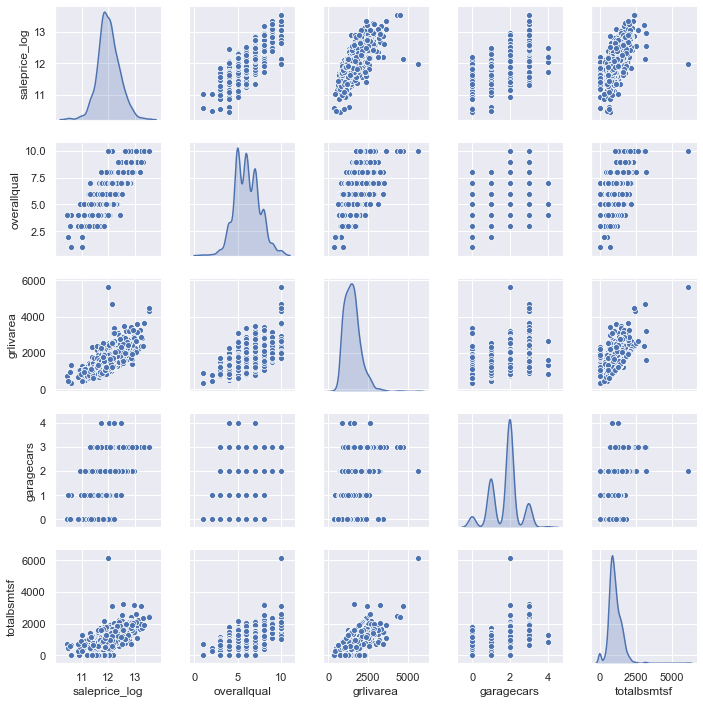

In [41]:
sns.set()
sns.pairplot(house_prices_df_clean_model[['saleprice_log', 'overallqual', 'grlivarea', 
                                               'garagecars', 'totalbsmtsf']],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

## Building our Regression Model Dataset

In [42]:
# Testing model with specified holdout group size = 20%
data = house_prices_df_clean_model.drop(['saleprice_log','street_Pave', 'mszoning_FV', 'mszoning_RH'], axis=1)
target = house_prices_df_clean_model.saleprice_log



size = 0.20

# data.head(20)

In [43]:
from sklearn.model_selection import train_test_split


# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=size, random_state=int(size*100))

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

from sklearn import linear_model
import statsmodels.formula.api as smf

# # Y is the target variable
Y = target
# # X is the feature set
X = data

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

The number of observations in training set is 1168
The number of observations in test set is 292

Coefficients: 
 [ 1.28856469e-01  1.98496820e-04  1.09423025e-01  1.13878267e-04
  6.59294946e-02 -9.97851416e-02]

Intercept: 
 10.586441263769078


In [44]:
# We add constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          saleprice_log   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     840.5
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        09:21:11   Log-Likelihood:                 375.43
No. Observations:                1168   AIC:                            -736.9
Df Residuals:                    1161   BIC:                            -701.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.5791      0.032    326.753      

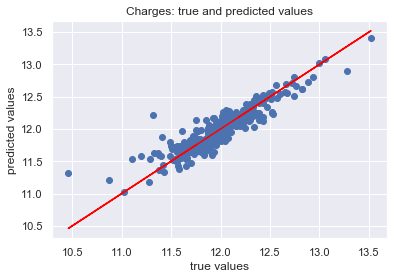

Mean absolute error of the prediction is: 0.11685710681616997
Mean squared error of the prediction is: 0.024957271962568386
Root mean squared error of the prediction is: 0.15797870730756214
Mean absolute percentage error of the prediction is: 0.9821014729185165


In [45]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse


# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [46]:
from sklearn.linear_model import LinearRegression

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.8128601159958619
-----Test set statistics-----
R-squared of the model in the test set is: 0.8198569975048499
Mean absolute error of the prediction is: 0.11685710681600477
Mean squared error of the prediction is: 0.024957271962533265
Root mean squared error of the prediction is: 0.15797870730745098
Mean absolute percentage error of the prediction is: 0.9821014729171005


# Hyperparameter selection & K-fold Cross Validation

Using a range of alpha values to test what the best Hyperparameters would be from the model chosen

In [47]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV


alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

### OLS Model

In [48]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8128601159958619
-----Test set statistics-----
R-squared of the model in test set is: 0.8198569975048499
Mean absolute error of the prediction is: 0.11685710681600477
Mean squared error of the prediction is: 0.024957271962533265
Root mean squared error of the prediction is: 0.15797870730745098
Mean absolute percentage error of the prediction is: 0.9821014729171005


### Ridge Model

In [49]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8128202648858357
-----Test set statistics-----
R-squared of the model in test set is: 0.8205295832972741
Mean absolute error of the prediction is: 0.11637477417031425
Mean squared error of the prediction is: 0.024864090954627504
Root mean squared error of the prediction is: 0.15768351516448226
Mean absolute percentage error of the prediction is: 0.9780894340946894


### Lasso Model

In [50]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.8128601159958617
-----Test set statistics-----
R-squared of the model in test set is: 0.8198569975880782
Mean absolute error of the prediction is: 0.11685710675185047
Mean squared error of the prediction is: 0.024957271951002703
Root mean squared error of the prediction is: 0.15797870727095695
Mean absolute percentage error of the prediction is: 0.9821014723831449


### ElasticNet Model

In [51]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8128599322905348
-----Test set statistics-----
R-squared of the model in test set is: 0.8199024771210922
Mean absolute error of the prediction is: 0.11682218831165607
Mean squared error of the prediction is: 0.024950971150758252
Root mean squared error of the prediction is: 0.15795876408340961
Mean absolute percentage error of the prediction is: 0.9818107531300955


# Analysis Summary

So from running 3 different models (Ridge, Lasso, and ElasticNet) we can see that the best model we should use is the Ridge Regression Model. This is observed through it having the highest R-squared score from the test data as well as having the lowest MAPE score. With a chosen Model ("Ridge") the best hyperparameter shown through alpha would be: **10**

## Extending our model with economic features

Next we will get the national short term interest rates, long term interest rates, total US Revenue, total US expenditures, and US bond rate for all the years in the analysis. To do this we will use JORDÀ-SCHULARICK-TAYLOR MACROHISTORY DATABASE to pull this data into our analysis.

**Source: http://www.macrohistory.net/data/#DownloadData**

### Add interest rates to the analysis dataset

In [52]:
# create interest rates dataframe
economic_data = pd.read_csv('US_InterestRates_JSTdatasetR4.csv')

economic_data.head(10)

,year,stir,ltrate,debtgdp,revenue,expenditure,bond_rate
0,1870,5.72,5.43,0.311886,0.411,0.310,0.054336
1,1871,5.56,5.36,0.302942,0.384,0.292,0.053567
2,1872,8.38,5.56,0.265976,0.374,0.278,0.055617
3,1873,14.24,5.48,0.243432,0.334,0.290,0.054792
4,1874,3.43,5.10,0.252240,0.305,0.303,0.051033
5,1875,3.11,4.63,0.261716,0.288,0.275,0.046300
6,1876,3.35,4.46,0.254035,0.294,0.265,0.044617
7,1877,3.87,4.35,0.244974,0.281,0.241,0.043492
8,1878,4.22,4.23,0.255250,0.268,0.237,0.042300
9,1879,5.44,4.04,0.243297,0.279,0.267,0.040367


In [53]:
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
year           147 non-null int64
stir           147 non-null float64
ltrate         147 non-null float64
debtgdp        147 non-null float64
revenue        147 non-null float64
expenditure    147 non-null float64
bond_rate      146 non-null float64
dtypes: float64(6), int64(1)
memory usage: 8.2 KB


To account for years with high variance we will create a feature called "rangerates" that is the _Short Term Interest Rate - Long Term Interest Rate_ that will help our model better understand "trigger years" such as stock market crashes.

In [54]:
economic_data['rangerates'] = np.abs(economic_data['ltrate'] - economic_data['stir'])

economic_data.head()

,year,stir,ltrate,debtgdp,revenue,expenditure,bond_rate,rangerates
0,1870,5.72,5.43,0.311886,0.411,0.310,0.054336,0.29
1,1871,5.56,5.36,0.302942,0.384,0.292,0.053567,0.20
2,1872,8.38,5.56,0.265976,0.374,0.278,0.055617,2.82
3,1873,14.24,5.48,0.243432,0.334,0.290,0.054792,8.76
4,1874,3.43,5.10,0.252240,0.305,0.303,0.051033,1.67


In [55]:
house_prices_df_clean.head()

,utilities,mssubclass,foundation,extercond,exterqual,exterior2nd,exterior1st,roofmatl,roofstyle,yearbuilt,...,salecondition,heating,totalbsmtsf,id,saleprice_log,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,AllPub,60,PConc,TA,Gd,VinylSd,VinylSd,CompShg,Gable,2003,...,Normal,GasA,856,1,12.247694,0,0,1,0,1
1,AllPub,20,CBlock,TA,TA,MetalSd,MetalSd,CompShg,Gable,1976,...,Normal,GasA,1262,2,12.109011,0,0,1,0,1
2,AllPub,60,PConc,TA,Gd,VinylSd,VinylSd,CompShg,Gable,2001,...,Normal,GasA,920,3,12.317167,0,0,1,0,1
3,AllPub,70,BrkTil,TA,TA,Wd Shng,Wd Sdng,CompShg,Gable,1915,...,Abnorml,GasA,756,4,11.849398,0,0,1,0,1
4,AllPub,60,PConc,TA,Gd,VinylSd,VinylSd,CompShg,Gable,2000,...,Normal,GasA,1145,5,12.429216,0,0,1,0,1


In [56]:
# create a list of economic columns to correlate to the saleprice_log
economic_features_list = list(economic_data.columns)
economic_features_list.append('saleprice_log')


house_prices_df_clean_economics = pd.merge(economic_data, house_prices_df_clean, how='right', left_on = 'year', right_on = 'yearbuilt')
    
house_prices_df_clean_economics.describe().T
    



,count,mean,std,min,25%,50%,75%,max
year,1460.0,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000
stir,1460.0,4.136630,2.510168,0.160000,1.960000,3.880000,5.300000,16.390000
ltrate,1460.0,4.957623,2.026020,1.950000,3.700000,4.330000,6.030000,13.910000
debtgdp,1460.0,0.501485,0.201362,0.024446,0.357000,0.550500,0.618000,1.189000
revenue,1460.0,822.148618,921.237226,0.288000,68.747750,230.799000,1827.452000,2567.985000
expenditure,1460.0,925.757715,1048.088138,0.258000,70.640000,245.707000,1788.950000,3517.677000
bond_rate,1460.0,0.049573,0.020261,0.019500,0.036950,0.043333,0.060292,0.139108
rangerates,1460.0,1.312116,0.947010,0.010000,0.540000,1.070000,1.890000,4.290000
mssubclass,1460.0,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
yearbuilt,1460.0,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000


Next we'll run a quick Correlation analysis to get an idea of how much it might help our model:

In [57]:
feature_correlations_economics = np.abs(house_prices_df_clean_economics[economic_features_list].corr())

print(feature_correlations_economics['saleprice_log'].sort_values(ascending= False), '\n')

saleprice_log    1.000000
revenue          0.620977
expenditure      0.620237
year             0.586570
debtgdp          0.282311
ltrate           0.156306
bond_rate        0.156283
rangerates       0.081472
stir             0.030635
Name: saleprice_log, dtype: float64 



### Initial analysis

Interesting results from our correlation analysis of the economic features in that long term and short term interest rates were both vastly lower in correlation our target feature 'saleprice_log' compared to total revenue and total expenditures.

To keep our model consisted we will be using the same **absolute threshold of ~.59 coefficient value** we defined earlier in our analysis to identify features for our model.

This means we will add **revenue** and **expenditure** to our model as new features.

In [58]:
original_model_features_list = list(house_prices_df_clean_model.drop(['saleprice_log','street_Pave', 'mszoning_FV', 'mszoning_RH'], axis=1).columns)

# print(original_model_columns)

economic_features_list = list(['revenue', 'expenditure'])


# Testing model with specified holdout group size = 20%
data = house_prices_df_clean_economics[original_model_features_list + economic_features_list]
target = house_prices_df_clean_economics.saleprice_log

# print(data.columns)

size = 0.20

# # data.head(20)


# house_prices_df_clean_economics = house_prices_df_clean_economics[[]]

In [59]:
from sklearn.model_selection import train_test_split


# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=size, random_state=int(size*100))

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

from sklearn import linear_model
import statsmodels.formula.api as smf

# # Y is the target variable
Y = target
# # X is the feature set
X = data

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

The number of observations in training set is 1168
The number of observations in test set is 292

Coefficients: 
 [ 1.09754511e-01  2.17235721e-04  9.38854925e-02  1.06959406e-04
  9.86057721e-02 -6.07539413e-02 -3.96210756e-05  7.74994005e-05]

Intercept: 
 10.638565197450573


In [60]:
# We add constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          saleprice_log   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     659.7
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        09:21:13   Log-Likelihood:                 423.95
No. Observations:                1168   AIC:                            -829.9
Df Residuals:                    1159   BIC:                            -784.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.6878      0.032    329.610      

Our new features did improve from our original OLS model R-Squared by _~0.07_ but that is a nominal improvement. Reduction in AIC and BIC is a good sign but the coefficient values are lower than all of our original model features witch most likely means they will not contribute much to our model but lets add them in and compare the results to our OLS and Ridge Regression models.

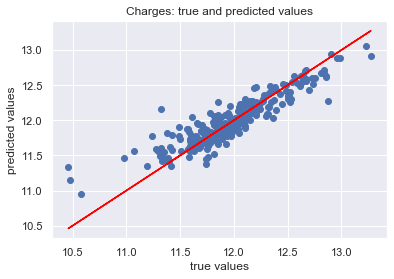

Mean absolute error of the prediction is: 0.12007874744936689
Mean squared error of the prediction is: 0.030295712242253504
Root mean squared error of the prediction is: 0.17405663515721975
Mean absolute percentage error of the prediction is: 1.0148143460847323


In [61]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse


# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The new features fit well other than a few outliers on the beginning and the end of our predictions.

## Rerun the Ridge regression model

In [62]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8199421703647248
-----Test set statistics-----
R-squared of the model in test set is: 0.8169352333332925
Mean absolute error of the prediction is: 0.12006726008567382
Mean squared error of the prediction is: 0.030284400693567273
Root mean squared error of the prediction is: 0.1740241382497476
Mean absolute percentage error of the prediction is: 1.0147150136210148


## Analysis of additional economic features into our Ridge Regression Model:

Due to the strength of our original features set our additional economic features 'revenue' and 'expenditure' did not improve our models accuracy. That being said the decline in performance was minimal with the R-squared of the model in the test reducing by only _0.00359_ and the MAPE reducing by _0.036_ which means if we did not have access to some of the original features these could possibly be used as replacement features if necessary. At this time I would not choose to add these as additional features even though they initially showed a high correlation with our target feature they add complexity to a robust model.